**11장 - 심층 신경망**

# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#tf.debugging.set_log_device_placement(True)
#a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
#c = tf.matmul(a, b)
#print(c)

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "11"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 그레디언트 소실과 폭주


## 수렴하지 않는 활성화 함수

### LeakyReLU

In [2]:
def LeakyRelu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

그림 저장: leaky_relu_plot


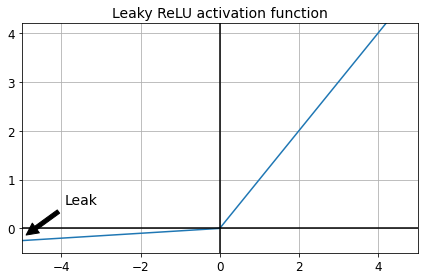

In [3]:
z = np.linspace(-5, 5, 200)
plt.plot(z, LeakyRelu(z, 0.05))
plt.plot([-5,5] , [0,0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

LeakyReLU를 사용한 패션 MNIST에서 신경망 훈련

In [4]:
(X_TrainFull, y_TrainFull), (X_Test, y_Test) = keras.datasets.fashion_mnist.load_data()
X_TrainFull = X_TrainFull/255.0
X_Test = X_Test/255.0
X_Valid, X_Train = X_TrainFull[:5000], X_TrainFull[5000:]
y_Valid, y_Train = y_TrainFull[:5000], y_TrainFull[5000:]

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28,28]),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(10, activation="softmax")
    ]
)

model.summary()
keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trai

2022-06-04 15:22:05.571494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 15:22:05.583348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 15:22:05.583479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 15:22:05.584407: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    metrics=["accuracy"]
)

In [7]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_Train, y_Train, epochs= 10,
                    validation_data=(X_Valid, y_Valid))

2022-06-04 15:22:24.125205: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.
2022-06-04 15:22:24.215838: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/10
 178/1719 [==>...........................] - ETA: 1s - loss: 2.0611 - accuracy: 0.2979

2022-06-04 15:22:24.981627: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 2s 939us/step - loss: 1.2819 - accuracy: 0.6228 - val_loss: 0.8886 - val_accuracy: 0.7158
Epoch 2/10
1719/1719 [==============================] - 2s 891us/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 2s 887us/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 2s 894us/step - loss: 0.6217 - accuracy: 0.7945 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 2s 887us/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8198
Epoch 6/10
1719/1719 [==============================] - 2s 886us/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8240
Epoch 7/10
1719/1719 [==============================] - 2s 890us/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val_accura

### LeakyReLU

In [8]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


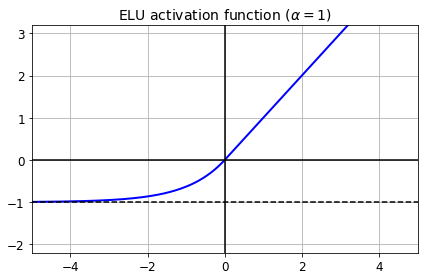

In [9]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

ELU 적용 : 층을 만들 때 활성화 함수로 지정!

In [10]:
keras.layers.Dense(10, activation="elu")

### SELU

시퀀셜한 모델과 사용 : 정규화, 드롭아웃, 스킵 연결 등 사용 불가

In [11]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 졍규화
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [12]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


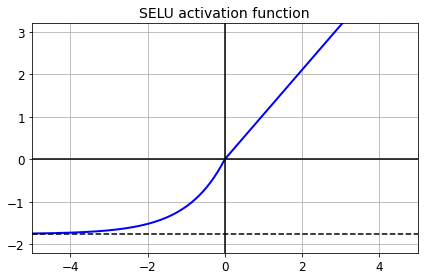

In [13]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

SELU 하이퍼파라미터(`scale`과 `alpha`)는 각 뉴런의 평균 출력이 0에 가깝고 표준 편차는 1에 가깝도록 조정.(입력은 평균이 0이고 표준 편차 1로 표준화되었다고 가정). 이 활성화 함수를 사용하면 1,000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준 편차를 1로 유지. 이를 통해 그레이디언트 폭주와 소실 문제를 피함

In [14]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


SELU 적용 : 층을 만들 때 활성화 함수로 지정!

In [15]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

SELU 활성화 함수를 사용한 MNIST 신경망

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

#model.summary()
#keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

훈련 시 입력을 평균 0, 표준편차 1로 바꿔주야 함.

In [18]:
pixelMeans = X_Train.mean(axis=0, keepdims=True)
pixelStds = X_Train.std(axis=0, keepdims=True)
X_TrainScaled = (X_Train - pixelMeans) / pixelStds
X_ValidScaled = (X_Valid - pixelMeans) / pixelStds
X_TestScaled = (X_Test - pixelMeans) / pixelStds

In [20]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-04 15:23:00.007349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 15:23:00.007496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 15:23:00.007565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 15:23:00.007678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 15:23:00.007750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16289265962345173911
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1974468608
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12132861191742692462
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [21]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_TrainScaled, y_Train, epochs=5,
                    validation_data=(X_ValidScaled, y_Valid))

2022-06-04 15:23:00.705572: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.
2022-06-04 15:23:00.782512: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/5
1719/1719 [==============================] - 12s 6ms/step - loss: 1.4909 - accuracy: 0.4164 - val_loss: 0.9834 - val_accuracy: 0.6436
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8020 - accuracy: 0.7030 - val_loss: 0.6527 - val_accuracy: 0.7646
Epoch 3/5
1719/1719 [==============================] - 9s 6ms/step - loss: 0.6459 - accuracy: 0.7682 - val_loss: 0.6181 - val_accuracy: 0.7766
Epoch 4/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5937 - accuracy: 0.7935 - val_loss: 0.5367 - val_accuracy: 0.8114
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5350 - accuracy: 0.8131 - val_loss: 0.5197 - val_accuracy: 0.8214


ReLU 활성화 함수 사용 : 그래디언트 폭주나 소실 문제 발생

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [24]:
history = model.fit(X_TrainScaled, y_Train, epochs=5,
                validation_data=(X_ValidScaled, y_Valid))

2022-06-04 15:25:15.224211: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/5
1719/1719 [==============================] - 11s 6ms/step - loss: 1.7898 - accuracy: 0.2781 - val_loss: 1.2900 - val_accuracy: 0.3962
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 1.1704 - accuracy: 0.5139 - val_loss: 1.1558 - val_accuracy: 0.5056
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 1.0322 - accuracy: 0.5628 - val_loss: 0.8987 - val_accuracy: 0.6096
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9250 - accuracy: 0.6213 - val_loss: 0.8273 - val_accuracy: 0.6806
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8656 - accuracy: 0.6564 - val_loss: 0.7496 - val_accuracy: 0.7166


## 배치 정규화

은닉층의 활성화 함수 전이나 후에 배치 정규화 층 사용

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_207 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_208 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [27]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [29]:
history = model.fit(X_Train, y_Train, epochs=10,
                    validation_data=(X_Valid, y_Valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8750 - accuracy: 0.7123 - val_loss: 0.5526 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5753 - accuracy: 0.8030 - val_loss: 0.4725 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5189 - accuracy: 0.8204 - val_loss: 0.4375 - val_accuracy: 0.8548
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4827 - accuracy: 0.8323 - val_loss: 0.4152 - val_accuracy: 0.8604
Epoch 5/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4565 - accuracy: 0.8408 - val_loss: 0.3997 - val_accuracy: 0.8646
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4398 - accuracy: 0.8473 - val_loss: 0.3867 - val_accuracy: 0.8696
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4242 - accuracy: 0.8515 - val_loss: 0.3764 - val_accuracy:

활성화 함수 이전 배치 정규화 층 사용

In [30]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),

    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])


In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [32]:
history = model.fit(X_Train, y_Train, epochs=10,
                    validation_data=(X_Valid, y_Valid))
                    

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 1.0317 - accuracy: 0.6756 - val_loss: 0.6767 - val_accuracy: 0.7816
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5565 - val_accuracy: 0.8178
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.5007 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5447 - accuracy: 0.8193 - val_loss: 0.4666 - val_accuracy: 0.8452
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5109 - accuracy: 0.8280 - val_loss: 0.4433 - val_accuracy: 0.8532
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4898 - accuracy: 0.8337 - val_loss: 0.4263 - val_accuracy: 0.8540
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4712 - accuracy: 0.8396 - val_loss: 0.4130 - val_accuracy:

## 그래디언트 클리핑

역전파 될 떄 일정 임곗값을 넘어가지 못하게 그래디언트를 잘라내는 것  
옵티마이저에 `clipnorm` 이나 `clipvalue` 매개변수 지정

In [33]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [34]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 사전 훈련된 층 재사용

전이학습 : 재사용하는 층을 동결, 재학습할 은닉층의 동결 해제 -> 학습!

패션 MNIST 훈련 세트를 두 개로 나누어 보죠:
* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

검증 세트와 테스트 세트도 이렇게 나눕니다. 하지만 이미지 개수는 제한하지 않습니다.

A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 보겠습니다. A 작업에서 B 작업으로 약간의 지식이 전달되기를 기대합니다.  
왜냐하면 A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷하기 때문입니다.  
하지만 `Dense` 층을 사용하기 때문에 동일한 위치에 나타난 패턴만 재사용할 수 있습니다.  (반대로 합성곱 층은 훨씬 많은 정보를 전송합니다. 학습한 패턴을 이미지의 어느 위치에서나 감지할 수 있기 때문입니다. CNN 장에서 자세히 알아 보겠습니다).

In [35]:
def split_dataset(X, y):
    y_5_or_6 = (y==5) | (y==6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

In [41]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_Train, y_Train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_Valid, y_Valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_Test, y_Test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [42]:
X_train_A.shape

(43986, 28, 28)

In [43]:
X_train_B.shape

(200, 28, 28)

In [44]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [45]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [46]:
tf.random.set_seed(42)
np.random.seed(42)

In [47]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation='selu'))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [48]:
model_A.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_213 (Dense)           (None, 300)               235500    
                                                                 
 dense_214 (Dense)           (None, 100)               30100     
                                                                 
 dense_215 (Dense)           (None, 50)                5050      
                                                                 
 dense_216 (Dense)           (None, 50)                2550      
                                                                 
 dense_217 (Dense)           (None, 50)                2550      
                                                                 
 dense_218 (Dense)           (None, 8)                

In [52]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [53]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2137 - accuracy: 0.9262 - val_loss: 0.2434 - val_accuracy: 0.9138
Epoch 2/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.2112 - accuracy: 0.9271 - val_loss: 0.2309 - val_accuracy: 0.9220
Epoch 3/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.2091 - accuracy: 0.9281 - val_loss: 0.2267 - val_accuracy: 0.9228
Epoch 4/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.2076 - accuracy: 0.9287 - val_loss: 0.2263 - val_accuracy: 0.9235
Epoch 5/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.2055 - accuracy: 0.9289 - val_loss: 0.2280 - val_accuracy: 0.9220
Epoch 6/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.2038 - accuracy: 0.9300 - val_loss: 0.2270 - val_accuracy: 0.9235
Epoch 7/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.2018 - accuracy: 0.9301 - val_loss: 0.2294 - val_accuracy:

In [54]:
model_A.save("model/my_model_A.h5")

In [55]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [56]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [58]:
model_B.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_219 (Dense)           (None, 300)               235500    
                                                                 
 dense_220 (Dense)           (None, 100)               30100     
                                                                 
 dense_221 (Dense)           (None, 50)                5050      
                                                                 
 dense_222 (Dense)           (None, 50)                2550      
                                                                 
 dense_223 (Dense)           (None, 50)                2550      
                                                                 
 dense_224 (Dense)           (None, 1)                

In [57]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 17ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6311 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.5692 - accuracy: 0.7500 - val_loss: 0.4784 - val_accuracy: 0.8540
Epoch 3/20
7/7 [==============================] - 0s 6ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 6ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 6ms/step - loss: 0.3434 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9310
Epoch 6/20
7/7 [==============================] - 0s 6ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3020 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 0.2801 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [=================

In [60]:
#model_A = keras.models.load_model("model/my_model_A.h5")
#model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
#model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

model_B_on_A와 model_A는 층을 공유하기 때문에 하나를 훈련하면 두 모델이 업데이트됩니다. 이를 피하려면 model_A를 클론한 것을 사용해 model_B_on_A를 만들어야 합니다:

In [72]:
model_A = keras.models.load_model("model/my_model_A.h5")
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

새로운 출력층이 랜덤하게 초기화 되므로 초기의 에포크 동안 큰 오차 생성 -> 재사용된 가중치를 망칠 수 있다.  
이를 피하기 위해 처음 몇 번의 에포크 동안 재사용된 층을 동결하고 새로운 층이 적절한 가중치를 학습하게 한다. -> 재사용 층 모두 동결

In [81]:
# 4에포크 동안 재사용 층 동결하여 학습
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 17ms/step - loss: 0.0477 - accuracy: 0.9900 - val_loss: 0.0715 - val_accuracy: 0.9878
Epoch 2/4
7/7 [==============================] - 0s 6ms/step - loss: 0.0474 - accuracy: 0.9900 - val_loss: 0.0711 - val_accuracy: 0.9878
Epoch 3/4
7/7 [==============================] - 0s 6ms/step - loss: 0.0470 - accuracy: 0.9900 - val_loss: 0.0707 - val_accuracy: 0.9878
Epoch 4/4
7/7 [==============================] - 0s 6ms/step - loss: 0.0467 - accuracy: 0.9900 - val_loss: 0.0704 - val_accuracy: 0.9878


In [82]:
# 초기 학습 이후 재사용층 동결 해체, 학습률 낮춰 학습
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

# optimizer 기본 학습률 : 1e-2
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-4),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 0s 17ms/step - loss: 0.0464 - accuracy: 0.9900 - val_loss: 0.0702 - val_accuracy: 0.9878
Epoch 2/16
7/7 [==============================] - 0s 13ms/step - loss: 0.0462 - accuracy: 0.9900 - val_loss: 0.0700 - val_accuracy: 0.9878
Epoch 3/16
7/7 [==============================] - 0s 8ms/step - loss: 0.0460 - accuracy: 0.9950 - val_loss: 0.0697 - val_accuracy: 0.9888
Epoch 4/16
7/7 [==============================] - 0s 6ms/step - loss: 0.0458 - accuracy: 0.9950 - val_loss: 0.0695 - val_accuracy: 0.9888
Epoch 5/16
7/7 [==============================] - 0s 6ms/step - loss: 0.0456 - accuracy: 0.9950 - val_loss: 0.0693 - val_accuracy: 0.9888
Epoch 6/16
7/7 [==============================] - 0s 6ms/step - loss: 0.0454 - accuracy: 0.9950 - val_loss: 0.0691 - val_accuracy: 0.9888
Epoch 7/16
7/7 [==============================] - 0s 6ms/step - loss: 0.0452 - accuracy: 0.9950 - val_loss: 0.0689 - val_accuracy: 0.9888
Epoch 8/16
7/7 [================

In [83]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 765us/step - loss: 0.1409 - accuracy: 0.9705


[0.14087168872356415, 0.9704999923706055]

In [84]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 804us/step - loss: 0.0573 - accuracy: 0.9920


[0.05728994682431221, 0.9919999837875366]

# 고속 옵티마이저

## 모멘텀 옵티마이저

In [85]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## 네스테로프 가속 경사

In [86]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad


In [87]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## RMSProp


In [88]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## Adam 옵티마이저

적응적 모멘트 추정 (Adaptive Moment Estimation) : 모멘텀 최적화 + RMSProp

In [89]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Adamax 옵티마이저

In [90]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Nadam 옵티마이저


Adam + 네스테로프 기법

In [91]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## 학습률 스케줄링

학습률을 너무 크게 잡으면 발산, 너무 작게 잡으면 최적점에 수렴하는데 너무 오랜 시간 소요  

큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추면 최적의 고정 학습률보다 좋은 솔루션을 빨리 발견할 수 있다.  

학습률 스케줄링 : 훈련하는 동안 학습률을 감소시키는 전략!

### 거듭제곱 스케줄링

```lr = lr0 / (1 + steps / s)**c```
* 케라스는 `c=1`과 `s = 1 / decay`을 사용합니다

In [92]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [93]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [97]:
n_epochs = 25
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid))

Epoch 1/25
1719/1719 [==============================] - 2s 936us/step - loss: 0.4893 - accuracy: 0.8282 - val_loss: 0.4011 - val_accuracy: 0.8646
Epoch 2/25
1719/1719 [==============================] - 2s 901us/step - loss: 0.3763 - accuracy: 0.8669 - val_loss: 0.3717 - val_accuracy: 0.8710
Epoch 3/25
1719/1719 [==============================] - 2s 903us/step - loss: 0.3438 - accuracy: 0.8777 - val_loss: 0.3747 - val_accuracy: 0.8706
Epoch 4/25
1719/1719 [==============================] - 2s 906us/step - loss: 0.3235 - accuracy: 0.8852 - val_loss: 0.3515 - val_accuracy: 0.8784
Epoch 5/25
1719/1719 [==============================] - 2s 896us/step - loss: 0.3090 - accuracy: 0.8904 - val_loss: 0.3427 - val_accuracy: 0.8802
Epoch 6/25
1719/1719 [==============================] - 2s 912us/step - loss: 0.2954 - accuracy: 0.8956 - val_loss: 0.3434 - val_accuracy: 0.8794
Epoch 7/25
1719/1719 [==============================] - 2s 904us/step - loss: 0.2858 - accuracy: 0.8992 - val_loss: 0.3381 -

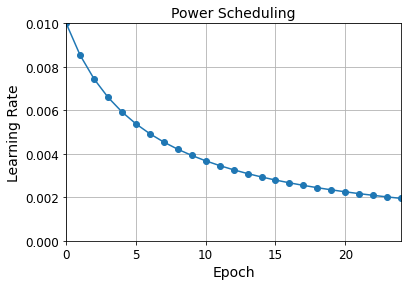

In [102]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_Train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케줄링


```lr = lr0 * 0.1**(epoch / s)```

스케줄링 함수 -> LearningRateScheduler 콜백 -> fit 메서드  

LearningRateScheduler : 에포크를 시작할 때마다 옵티마이저의 learning_rate 업데이트  



In [105]:
# 현재 에포크를 받아 학습률을 반환하는 함수 
# lr0 = 0.1, step = 20, 20epoch 마다 1/10씩 감소
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [106]:
# lr0 와 s를 변수로 설정한 클로저를 반환하는 함수
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [107]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [109]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8203 - accuracy: 0.7603 - val_loss: 0.9031 - val_accuracy: 0.7256 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7237 - accuracy: 0.7878 - val_loss: 0.6939 - val_accuracy: 0.8118 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6296 - accuracy: 0.8109 - val_loss: 0.5951 - val_accuracy: 0.8314 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5761 - accuracy: 0.8310 - val_loss: 0.5611 - val_accuracy: 0.8308 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5167 - accuracy: 0.8450 - val_loss: 0.6123 - val_accuracy: 0.8448 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4629 - accuracy: 0.8571 - val_loss: 0.5393 - val_accuracy: 0.8532 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 2s

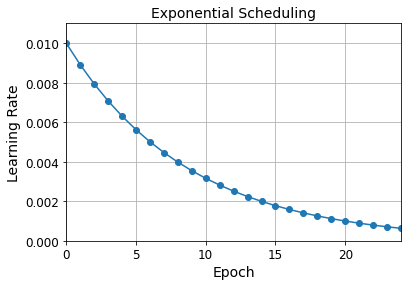

In [110]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

두 번째 매개변수로 현재 학습률을 사용하는 스케줄 함수

In [111]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

에포크가 아니라 반복마다 학습률을 업데이트하려면 사용자 정의 콜백 클래스 작성 필요

In [112]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [113]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [117]:
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_Train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7910 - accuracy: 0.7684 - val_loss: 0.7787 - val_accuracy: 0.7724 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6472 - accuracy: 0.8020 - val_loss: 0.6394 - val_accuracy: 0.8448 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5617 - accuracy: 0.8264 - val_loss: 0.5955 - val_accuracy: 0.8456 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5256 - accuracy: 0.8370 - val_loss: 0.4660 - val_accuracy: 0.8466 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4557 - accuracy: 0.8558 - val_loss: 0.4555 - val_accuracy: 0.8670 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4214 - accuracy: 0.8663 - val_loss: 0.4481 - val_accuracy: 0.8690 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 3s

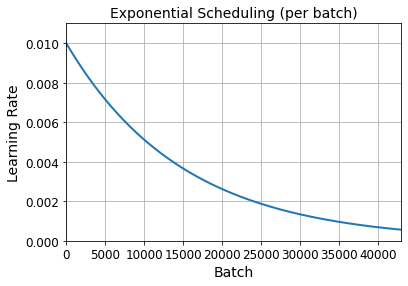

In [119]:
n_steps = n_epochs * len(X_Train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### 기간별 고정 스케줄링

In [120]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [121]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [123]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [124]:
n_epochs = 25
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8386 - accuracy: 0.7600 - val_loss: 0.8521 - val_accuracy: 0.7546 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.8212 - accuracy: 0.7639 - val_loss: 0.8510 - val_accuracy: 0.7366 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.8526 - accuracy: 0.7601 - val_loss: 0.8606 - val_accuracy: 0.7090 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.8884 - accuracy: 0.7543 - val_loss: 0.9883 - val_accuracy: 0.6606 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.9769 - accuracy: 0.7096 - val_loss: 1.2551 - val_accuracy: 0.6530 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5769 - accuracy: 0.8215 - val_loss: 0.6418 - val_accuracy: 0.8362 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 2s

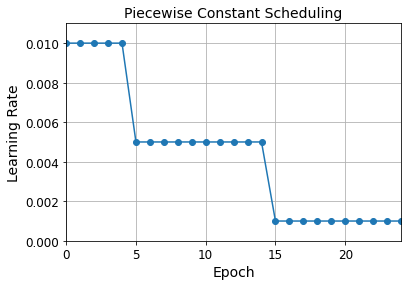

In [125]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 성능 기반 스케줄링

In [126]:
tf.random.set_seed(42)
np.random.seed(42)

In [127]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [128]:
n_epochs = 25
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4734 - accuracy: 0.8347 - val_loss: 0.3834 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3440 - accuracy: 0.8740 - val_loss: 0.3587 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3050 - accuracy: 0.8870 - val_loss: 0.3368 - val_accuracy: 0.8790 - lr: 0.0010
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2800 - accuracy: 0.8950 - val_loss: 0.3333 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2594 - accuracy: 0.9029 - val_loss: 0.3270 - val_accuracy: 0.8868 - lr: 0.0010
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2421 - accuracy: 0.9089 - val_loss: 0.3545 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 7/25
1719/1719 [==============================] - 2s

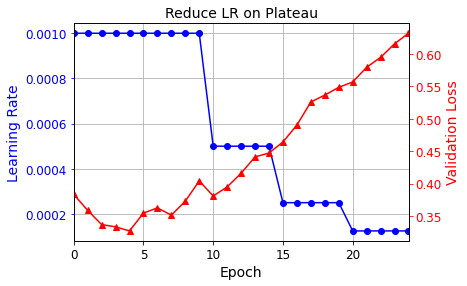

In [129]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras 스케줄러

In [132]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

앞서 만든 지수기반 스케줄링과 동일한 구현

In [135]:
s = 20 * len(X_Train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [137]:
n_epochs = 25
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid))

Epoch 1/25
1719/1719 [==============================] - 2s 905us/step - loss: 0.3779 - accuracy: 0.8658 - val_loss: 0.3749 - val_accuracy: 0.8646
Epoch 2/25
1719/1719 [==============================] - 2s 910us/step - loss: 0.3448 - accuracy: 0.8773 - val_loss: 0.3593 - val_accuracy: 0.8764
Epoch 3/25
1719/1719 [==============================] - 2s 912us/step - loss: 0.3228 - accuracy: 0.8851 - val_loss: 0.3637 - val_accuracy: 0.8714
Epoch 4/25
1719/1719 [==============================] - 2s 915us/step - loss: 0.3069 - accuracy: 0.8899 - val_loss: 0.3436 - val_accuracy: 0.8830
Epoch 5/25
1719/1719 [==============================] - 2s 922us/step - loss: 0.2948 - accuracy: 0.8951 - val_loss: 0.3380 - val_accuracy: 0.8802
Epoch 6/25
1719/1719 [==============================] - 2s 915us/step - loss: 0.2832 - accuracy: 0.8999 - val_loss: 0.3385 - val_accuracy: 0.8838
Epoch 7/25
1719/1719 [==============================] - 2s 918us/step - loss: 0.2745 - accuracy: 0.9029 - val_loss: 0.3336 -

앞서 만든 구간별 고정 스케줄링과 동일

In [139]:
n_steps_per_epoch = math.ceil(len(X_Train) / batch_size)
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5.*n_steps_per_epoch, 15.*n_steps_per_epoch],
    values =[0.001, 0.005, 0.001])
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [140]:
n_epochs = 25
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid))

Epoch 1/25
1719/1719 [==============================] - 2s 974us/step - loss: 0.2170 - accuracy: 0.9249 - val_loss: 0.3211 - val_accuracy: 0.8886
Epoch 2/25
1719/1719 [==============================] - 2s 938us/step - loss: 0.2158 - accuracy: 0.9247 - val_loss: 0.3200 - val_accuracy: 0.8926
Epoch 3/25
1719/1719 [==============================] - 2s 931us/step - loss: 0.2146 - accuracy: 0.9260 - val_loss: 0.3214 - val_accuracy: 0.8896
Epoch 4/25
1719/1719 [==============================] - 2s 938us/step - loss: 0.2133 - accuracy: 0.9263 - val_loss: 0.3179 - val_accuracy: 0.8890
Epoch 5/25
1719/1719 [==============================] - 2s 927us/step - loss: 0.2124 - accuracy: 0.9260 - val_loss: 0.3194 - val_accuracy: 0.8874
Epoch 6/25
1719/1719 [==============================] - 2s 928us/step - loss: 0.2248 - accuracy: 0.9201 - val_loss: 0.3264 - val_accuracy: 0.8888
Epoch 7/25
1719/1719 [==============================] - 2s 930us/step - loss: 0.2202 - accuracy: 0.9225 - val_loss: 0.3270 -

### 1사이클 스케줄링

In [143]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**경고**: `on_batch_end()` 메서드에서 `logs["loss"]`로 배치 손실을 모으지만 텐서플로 2.2.0에서 (에포크의) 평균 손실로 바뀌었습니다. (텐서플로 2.2 이상을 사용한다면) 이런 이유로 아래 그래프가 이전보다 훨씬 부드럽습니다. 이는 그래프에서 배치 손실이 폭주하기 시작하는 지점과 그렇지 않은 지점 사이에 지연이 있다는 뜻입니다. 따라서 변동이 심한 그래프에서는 조금 더 작은 학습률을 선택해야 합니다. 또한 `ExponentialLearningRate` 콜백을 조금 바꾸어 (현재 평균 손실과 이전 평균 손실을 기반으로) 배치 손실을 계산할 수 있습니다:

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)|
```

In [144]:
tf.random.set_seed(42)
np.random.seed(42)

In [145]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.3863    


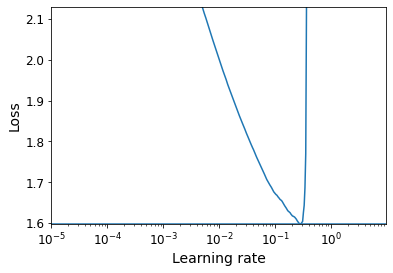

In [148]:
batch_size = 128
rates, losses = find_learning_rate(model, X_TrainScaled, y_Train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [150]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [153]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_Train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_ValidScaled, y_Valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 1ms/step - loss: 0.6573 - accuracy: 0.7738 - val_loss: 0.4873 - val_accuracy: 0.8338
Epoch 2/25
430/430 [==============================] - 0s 1ms/step - loss: 0.4581 - accuracy: 0.8395 - val_loss: 0.4275 - val_accuracy: 0.8520
Epoch 3/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4122 - accuracy: 0.8546 - val_loss: 0.4115 - val_accuracy: 0.8592
Epoch 4/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3837 - accuracy: 0.8641 - val_loss: 0.3872 - val_accuracy: 0.8680
Epoch 5/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3640 - accuracy: 0.8715 - val_loss: 0.3765 - val_accuracy: 0.8682
Epoch 6/25
430/430 [==============================] - 0s 1ms/step - loss: 0.3457 - accuracy: 0.8773 - val_loss: 0.3740 - val_accuracy: 0.8716
Epoch 7/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 0.3633 - val_accuracy: 0.8716
Epoch 

# 규제를 사용해 과대적합 피하기

## $\ell_1$과 $\ell_2$ 규제

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [154]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [155]:
n_epochs = 2
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid))

Epoch 1/2
1719/1719 [==============================] - 3s 1ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7197 - accuracy: 0.8273 - val_loss: 0.6850 - val_accuracy: 0.8376


일반적으로 네트워크의 모든 은닉층에 동일한 활성화 함수, 동일한 초기화 전략, 동일한 규제를 적용하기 댸문에 동일한 매개변수 값을 반복하는 경우가 많다.  

이는 코드를 읽기 어렵게 만들고 버그를 만들기 쉽다.  

1. 반복문을 사용하여 코드 리팩터링
2. 파이썬의 functools.partial()을 사용하여 기본 매개변수 값을 사용하여 함수 호출을 감싸서 사용

In [170]:
# 1. 반복문 사용 - 위에랑 다르긴 하다, 이거는 아래의 층 세번 반복
# keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01)))
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for layer in range(2):
    model.add(keras.layers.Dense(300, activation="elu",
                                kernel_initializer="he_normal",
                                kernel_regularizer=keras.regularizers.l2(0.01)))
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [169]:
# 2. 파이썬의 functools.partial() 사용
from functools import partial
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [171]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [172]:
n_epochs = 2
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid))

Epoch 1/2
1719/1719 [==============================] - 3s 1ms/step - loss: 1.6823 - accuracy: 0.8121 - val_loss: 0.7139 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7187 - accuracy: 0.8271 - val_loss: 0.6812 - val_accuracy: 0.8368


## 드롭아웃

매 훈련 스텝에서 드롭아웃 비율 p만큼 뉴런 제외.  
이번 훈련 스텝에서는 무시되지만 다음 스텝에서는 활성화 될 수 있다.  
훈련이 끝난 후에는 뉴런에 더 이상 드롭아웃 적용하지 않음.

In [173]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [175]:
n_epochs = 2
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid))

Epoch 1/2
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5640 - accuracy: 0.8064 - val_loss: 0.3610 - val_accuracy: 0.8664
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4181 - accuracy: 0.8461 - val_loss: 0.3403 - val_accuracy: 0.8722


모델이 과대적합 됐다면 드롭아웃 비율을 늘릴 수 있다. 반대로 모델이 훈련 세트에 과소적합되면 드롭아웃 비율을 낮춰야 한다.  

층이 클 때는 드롭아웃 비율을 높이고 작은 층에서는 드롭아웃 비율을 낮춤  

마지막 은닉층 뒤에만 드롭아웃을 사용하는 경우도 많음 <- 드롭아웃을 전체에 적용하는 것이 너무 강하다면 이 방법 추천

## 맥스 노름

각각의 뉴런에 대해 입력의 연결가중치 w가 ||w||_2 =< r 이 되도록 제한  
|| . ||_2는 l_2노름, r은 맥스-노름 하이퍼파라미터

In [186]:
# 적절한 최댓값으로 지정한 max_norm()이 반환한 객체로 은닉층의 kernel_constraint 매개변수 지정
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [187]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

In [188]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [190]:
n_epochs = 2
history = model.fit(X_TrainScaled, y_Train, epochs=n_epochs,
                    validation_data=(X_ValidScaled, y_Valid))

Epoch 1/2
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4748 - accuracy: 0.8347 - val_loss: 0.3694 - val_accuracy: 0.8682
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3541 - accuracy: 0.8710 - val_loss: 0.3875 - val_accuracy: 0.8580
